In [1]:
import numpy as np
import pandas as pd
import open3d as o3d
import matplotlib.pyplot as plt
from shapely.geometry import Polygon

print(f"Open 3D Version: {o3d.__version__}")

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
Open 3D Version: 0.18.0


In [2]:
pc_dataset="./project.xyz"
mesh_dataset="./project.obj"
result_folder="./"

In [3]:
pcd_df= pd.read_csv(pc_dataset, delimiter=";")
print(pcd_df.columns)

Index(['//X', 'Y', 'Z', 'R', 'G', 'B', 'Classification'], dtype='object')


In [4]:
pcd_o3d=o3d.geometry.PointCloud(o3d.utility.Vector3dVector(np.array(pcd_df[['//X','Y','Z']])))

In [5]:
pcd_o3d.colors = o3d.utility.Vector3dVector( np.array( pcd_df[['R','G','B']]) / 255 )

In [6]:
mesh=o3d.io.read_triangle_mesh(mesh_dataset)
mesh.paint_uniform_color([0.9,0.9,0.9])

TriangleMesh with 2273 points and 2135 triangles.

In [7]:
o3d.visualization.draw_geometries([pcd_o3d,mesh])

In [8]:
# 1=미분류, 2=지상, 6=건물, 9=물, 26=휴식
pcd_df['Classification'].unique()
colors=np.zeros((len(pcd_df), 3))
colors[pcd_df['Classification'] == 2] = [0,0,0]
colors[pcd_df['Classification'] == 6] = [1,0,0]
colors[pcd_df['Classification'] == 9] = [0,0,0]
colors[pcd_df['Classification'] == 26] = [0,0,0]
pcd_o3d.colors = o3d.utility.Vector3dVector(colors)

In [9]:
# KD-트리 데이터 구조 생성
pcd_tree = o3d.geometry.KDTreeFlann(pcd_o3d)

In [38]:
# 1. 거리 임계값 설정
dist_POI = 50
# 2. 메쉬의 중심 좌표를 POI로 설정
POI=mesh.get_center()

In [44]:
# KD-트리를 사용하여 POI(집)로부터의 거리에 따른 포인트 선택
[k, idx, _] = pcd_tree.search_radius_vector_3d(POI, dist_POI)
pcd_selection=pcd_o3d.select_by_index(idx)

In [46]:
o3d.visualization.draw_geometries([pcd_selection,mesh])

In [48]:
o3d.visualization.draw_geometries_with_vertex_selection([pcd_selection])

[Open3D INFO] Clearing all points from selection.
[Open3D INFO] Adding point #1764 (120749.12, 487591.67, 12.12) to selection.
[Open3D INFO] Adding point #2268 (120765.05, 487615.53, 14.36) to selection.
[Open3D INFO] Adding point #2612 (120787.21, 487603.90, 8.76) to selection.
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: 요청한 변환 작업을 지원할 수 없습니다. 
[Open3D INFO] Adding point #746 (120768.32, 487575.79, 2.96) to selection.


In [54]:
o3d_parcel_corners=pcd_selection.select_by_index([1764  ,2268  ,2612  ,746])

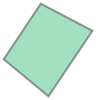

In [56]:
o3d_parcel_corners=np.array(o3d_parcel_corners.points)[:,:2]
Polygon(o3d_parcel_corners)

In [57]:
pgon = Polygon(o3d_parcel_corners) 
print ( f"이것은 얻은 소포 면적입니다: {pgon.area} m²" )

이것은 얻은 소포 면적입니다: 776.8449676724545 m²


In [58]:
def sort_coordinates(XY):
    cx, cy = XY.mean(0)
    x, y = XY.T
    angles = np.arctan2(x-cx, y-cy)
    indices = np.argsort(-angles)
    return XY[indices]

In [59]:
np_sorted_2D_corners=sort_coordinates(o3d_parcel_corners)
pgon = Polygon(np_sorted_2D_corners)
Polygon(np_sorted_2D_corners)
print(f"This is the parcel area: {pgon.area} m²")

This is the parcel area: 776.8449676724545 m²


In [60]:
pcd_selection.get_max_bound()
pcd_selection.get_min_bound()

array([ 1.2073525e+05,  4.8755321e+05, -4.1999999e-01])

In [69]:
np_pcd_selection=np.array(pcd_selection.points)
lowest_point_index=np.argmin(np_pcd_selection[:,2])
highest_point_index=np.argmax(np_pcd_selection[:,2])

In [70]:
# We create 3D Spheres to add them to our visual scene
lp=o3d.geometry.TriangleMesh.create_sphere()
hp=o3d.geometry.TriangleMesh.create_sphere()

# We translate the 3D Spheres to the correct position
lp.translate(np_pcd_selection[lowest_point_index])
hp.translate(np_pcd_selection[highest_point_index])

# We compute some normals and give color to each 3D Sphere
lp.compute_vertex_normals()
lp.paint_uniform_color([0.8,0.1,0.1])
hp.compute_vertex_normals()
hp.paint_uniform_color([0.1,0.1,0.8])

# We generate the scene
o3d.visualization.draw_geometries([pcd_selection,lp,hp])

In [67]:
voxel_grid = o3d.geometry.VoxelGrid.create_from_point_cloud(pcd_selection, voxel_size=1)
o3d.visualization.draw_geometries([voxel_grid])

In [72]:
colors=np.zeros((len(pcd_df), 3))
colors[pcd_df['Classification'] == 6] = [1, 0, 0]
pcd_o3d.colors = o3d.utility.Vector3dVector(colors)

In [74]:
# Defining the POI and the center of study
dist_POI=50
POI=mesh.get_center()

# Querying all the points that fall within based on a KD-Tree
pcd_tree = o3d.geometry.KDTreeFlann(pcd_o3d)
[k, idx, _] = pcd_tree.search_radius_vector_3d(POI, dist_POI)
pcd_selection=pcd_o3d.select_by_index(idx)

#Computing the voxel grid and visualizing the results
voxel_grid = o3d.geometry.VoxelGrid.create_from_point_cloud(pcd_selection, voxel_size=1)
o3d.visualization.draw_geometries([voxel_grid])

In [76]:
idx_voxels=[v.grid_index for v in voxel_grid.get_voxels()]
color_voxels=[v.color for v in voxel_grid.get_voxels()]
bounds_voxels=[np.min(idx_voxels, axis=0),np.max(idx_voxels, axis=0)]

In [77]:
max_voxel={}
max_color={}

In [78]:
for idx, v in enumerate(idx_voxels):
    if (v[0],v[1]) in max_voxel.keys():
        if v[2]>max_voxel[(v[0],v[1])]:
            max_voxel[(v[0],v[1])]=v[2]
            max_color[(v[0],v[1])]=color_voxels[idx]
    else:
        max_voxel[(v[0],v[1])]=v[2]
        max_color[(v[0],v[1])]=color_voxels[idx]

In [80]:
count_building_coverage,count_non_building=0,0
for col in list(max_color.values()):
    if np.all(col==0):
        count_non_building+=1
    else:
        count_building_coverage+=1

In [81]:
print(f"Coverage of Buildings: {count_building_coverage*4} m²")   
print(f"Coverage of the Rest: {count_non_building*4} m²")
print(f"Built Ratio: {(count_building_coverage*4)/(count_building_coverage*2+count_non_building*2)} m²") 

Coverage of Buildings: 0 m²
Coverage of the Rest: 11236 m²
Built Ratio: 0.0 m²
